# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [48]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using ExpFamilyDistributions
using Random

using Revise
using BayesianModels

using BasicDataLoaders

# Plotting function
include("plotting.jl");

 Activating environment at `~/GithubRepositories/PPCA/Project.toml`


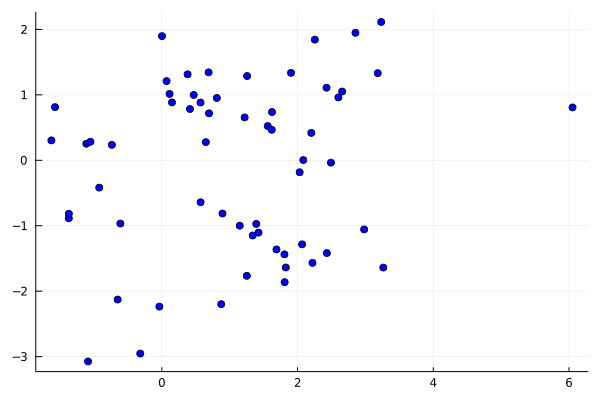

In [49]:
Random.seed!(100)

T = Float64

μ₁ = T[1, 1] 
Σ₁ = T[2. 0; 0  0.3]

μ₂ = T[-1, -1] 
Σ₂ = T[0.3 0; 0  2]

μ₃ = T[2, -1] 
Σ₃ = T[0.5 0; 0  0.5]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    [μ + L*randn(T, 2) for i in 1:n] 
end

X₁ = draw(30, μ₁, Σ₁)
X₂ = draw(10, μ₂, Σ₂)
X₃ = draw(20, μ₃, Σ₃)

X = vcat(X₁, X₂, X₃)

scatter(getindex.(X₁, 1), getindex.(X₁, 2), color = :blue, legend = false)
scatter!(getindex.(X₂, 1), getindex.(X₂, 2), color = :blue)
scatter!(getindex.(X₃, 1), getindex.(X₃, 2), color = :blue)

In [92]:
K = 5
normals = [BayesianModels.NormalDiag(datadim = 2, pstrength = 1, init_noise_std = 0.1) for i in 1:K]
model = Mixture(components = normals)

Mixture{5,BayesianModels.NormalDiag{2}}:
  π: BayesParam{Dirichlet{Float64,5},Dirichlet{Float64,5}}
  components: NTuple{5,BayesianModels.NormalDiag{2}}


In [93]:
elbo(model, X)

-359.17179310008845

In [97]:
X[1] |> model

5-element Array{Float64,1}:
 0.2283477725286613
 0.1829289916592856
 0.20344464759257602
 0.22348256093756858
 0.1617960272819081

In [69]:
using StatsFuns: logsumexp
logsumexp(BayesianModels.loglikelihood(model, X[1]))

-4.222560407860308

In [70]:
BayesianModels.loglikelihood(model, X)

60-element Array{Float64,1}:
  -4.222560407860308
  -3.9058005167847742
 -10.80320347164981
  -4.855199628452936
  -5.248791218762438
  -4.0527423624219185
  -7.645001813650749
  -4.275450161016466
  -3.8997921519273477
  -9.339657189726802
  -4.006060715256236
  -4.460323357970516
  -4.104440661567134
   ⋮
  -7.508397291773588
 -10.194113400132784
  -5.599240299735815
  -5.918764853387322
  -4.291774549296137
  -5.920497302418162
  -6.387955412377949
  -5.683869599826376
  -6.228021304050236
  -3.9280276601296906
  -8.524504786976493
  -6.5152552295485915

In [54]:
normal = normals[1]
Tη = vectorize(normal)
Tx = statistics.([normal], X) 
BayesianModels.loglikelihood(normal, X[1])
BayesianModels.loglikelihood(normal, X)

60-element Array{Float64,1}:
  -3.0142470340906247
  -2.709526100453368
 -10.502745531185138
  -4.021169558842766
  -4.045374077183027
  -2.964106442959797
  -7.048305932250744
  -3.251294402132059
  -2.7686742017528516
  -8.919805957110235
  -2.946015677589144
  -3.5375078102200477
  -2.99270913144085
   ⋮
  -6.892187065320008
  -9.81085390718501
  -4.880714811293975
  -5.100675101848464
  -3.2640006628496567
  -4.989075885121817
  -5.364362769216616
  -4.983083024172144
  -5.44162448646421
  -2.8179703937580443
  -8.062495064742073
  -5.798994818947547

In [33]:
lnπ = gradlognorm(model.π.posterior)

5-element Array{Float64,1}:
 -4.711824231690656
 -4.711824231690656
 -4.711824231690656
 -4.711824231690656
 -4.711824231690656

In [48]:
logsumexp([BayesianModels.loglikelihood(comp, X) .+ lnπᵢ for (comp, lnπᵢ) in zip(model.components, lnπ)])

LoadError: MethodError: no method matching AbstractFloat(::Type{Array{Float64,1}})
Closest candidates are:
  AbstractFloat(!Matched::Bool) at float.jl:258
  AbstractFloat(!Matched::Int8) at float.jl:259
  AbstractFloat(!Matched::Int16) at float.jl:260
  ...

In [93]:
x = X[1]
Tx = vcat(x, x.^2, 1)

5-element Array{Float64,1}:
 0.06925507050502888
 1.2101902735927759
 0.004796264790656522
 1.4645604982985576
 1.0

In [99]:
normal = model.components[1]

Tλ = gradlognorm.(getproperty.(normal.λ, :posterior), vectorize = false)
λ, lnλ = getindex.(Tλ,1), getindex.(Tλ,2)
μ, μ² = gradlognorm(normal.μ.posterior, vectorize = false)

Tη = vcat(λ .* μ, -.5 * λ, -.5 * (λ' * μ² + sum(lnλ))) 

5-element Array{Float64,1}:
 -0.04743577630696468
  0.09411136903551996
 -0.5
 -0.5
 -0.4283378864262607

In [53]:
using StatsFuns: logsumexp

r = hcat([BayesianModels.loglikelihood(comp, X) .+ lnπᵢ for (comp, lnπᵢ) in zip(model.components, lnπ)]...)
norm = logsumexp(r, dims = 2)
collect(eachcol(exp.(r .- norm)))

5-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1}:
 [0.2080747788548369, 0.20441749703771944, 0.16509871171549617, 0.18000694544141832, 0.2140327728951103, 0.19778434553512983, 0.17816183981560535, 0.1945261343611402, 0.19950490901552764, 0.16976776465128865  …  0.1681390149397607, 0.16452274785221802, 0.18018515387358186, 0.16760673397243664, 0.16944924123369237, 0.16864830711275042, 0.16231870578955282, 0.18632910633987154, 0.14885502852536683, 0.1598062387046924]
 [0.19828865222748196, 0.20049237850812876, 0.2560087748529536, 0.22739604022878743, 0.19526167347390025, 0.20813611495085735, 0.23754162351939156, 0.21240313036631359, 0.20551042208092016, 0.24897029436833035  …  0.23758842269287084, 0.23210940790165857, 0.21682106435496262, 0.2239906284836994, 0.21700234299356824, 0.238352830090722, 0.2343652286436431, 0.21071142327490658, 0.2569713955151309, 0.23928292201880097]
 [0.2138903776538495, 0.20895290984388737, 0.18607600019

In [6]:
lrate = 0.1
epochs = 100
batchsize = 10

elbos = [elbo(model, dl)]

for epoch in 1:epochs
    
    dl = DataLoader(shuffle(vcat(X₁, X₂, X₃)), batchsize = batchsize)
    for batch in dl
        scale = length(dl)
    
        # Gradient update 
        for (param, ∇L) in ∇elbo(model, batch, stats_scale = scale)
            η = naturalparam(param.posterior) + lrate*∇L
            update!(param.posterior, η)
        end
    end
    
    push!(elbos, elbo(model, dl))
end

plot(elbos)

LoadError: UndefVarError: model not defined

In [124]:
gradlognorm(model.μ.posterior)

4-element Array{Float64,1}:
  0.9318407519512345
 -0.26634512435207114
  1.113186145694532
  0.30142776935396803

In [26]:
s = μstats(model, dl[1])
#vcat(getindex.(s, 1), getindex.(s, 2))

4-element Array{Float64,1}:
 11.914475966940637
 13.037394088780065
 -5.0
 -5.0

In [31]:
getparam_stats(model, dl[1])

Dict{BayesParam,Array{T,1} where T} with 3 entries:
  BayesParam{Gamma{Float64},Gamma{Float64}}(G… => [-18.6419, 5.0]
  BayesParam{NormalDiag{Float64,2},NormalDiag… => [11.9145, 13.0374, -5.0, -5.0]
  BayesParam{Gamma{Float64},Gamma{Float64}}(G… => [-15.0381, 5.0]

In [35]:
function monitor(epoch)
    𝓛 = elbo(model, X)
    println("epoch: $epoch 𝓛 = $𝓛")
end

fit!(model, dl, epochs = 100, callback = monitor)

LoadError: MethodError: no method matching fit!(::PPCAModel{Float64,2,2}, ::DataLoader{Array{Array{Float64,1},1}}; epochs=100, batchsize=10, callback=monitor)
Closest candidates are:
  fit!(::PPCAModel, ::Any; epochs, callback) at /home/lucas/GithubRepositories/PPCA/src/model.jl:158 got unsupported keyword argument "batchsize"

In [11]:
PPCA.loglikelihood(model, X)

30-element Array{Float64,1}:
  -998.6404479602035
  -998.4621610503211
 -1001.8006250143707
  -998.8292172894928
  -999.0388160456082
  -998.3844609138455
  -999.887519530657
  -998.4372970178565
  -998.3582787403415
 -1000.9523938435913
  -998.3451851159278
  -998.554859978746
  -998.4286497661419
     ⋮
  -998.53158655683
 -1000.5232306640667
  -998.8510404758227
  -999.3276218444682
  -998.5688155314732
 -1000.5135499400864
 -1000.0895730665771
  -998.2224783896842
  -998.9202914117858
  -999.6961460781422
  -999.3529721168882
 -1013.0458694873977